<a href="https://colab.research.google.com/github/dominikmandok/tud-nlp/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/kwang2049/nlp4web-codebase.git
!git clone https://github.com/kwang2049/nlp4web-codebase.git  # You can always check the content of this simple codebase at any time
!pip install gradio  # we also need this additionally for this homework

  Cloning https://github.com/kwang2049/nlp4web-codebase.git to /tmp/pip-req-build-1ya902m_
  Running command git clone --filter=blob:none --quiet https://github.com/kwang2049/nlp4web-codebase.git /tmp/pip-req-build-1ya902m_
  Resolved https://github.com/kwang2049/nlp4web-codebase.git to commit 83f9afbbf7e372c116fdd04997a96449007f861f
  Preparing metadata (setup.py) ... done
fatal: destination path 'nlp4web-codebase' already exists and is not an empty directory.


## Pre-requisite code

The code within this section will be used in the tasks. Please do not change these code lines.

In [4]:
from dataclasses import dataclass
import pickle
import os
from typing import Iterable, Callable, List, Dict, Optional, Type, TypeVar
from nlp4web_codebase.ir.data_loaders.dm import Document
from collections import Counter
import tqdm
import re
import nltk
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords as nltk_stopwords

LANGUAGE = "english"
word_splitter = re.compile(r"(?u)\b\w\w+\b").findall
stopwords = set(nltk_stopwords.words(LANGUAGE))


def word_splitting(text: str) -> List[str]:
    return word_splitter(text.lower())

def lemmatization(words: List[str]) -> List[str]:
    return words  # We ignore lemmatization here for simplicity

def simple_tokenize(text: str) -> List[str]:
    words = word_splitting(text)
    tokenized = list(filter(lambda w: w not in stopwords, words))
    tokenized = lemmatization(tokenized)
    return tokenized

T = TypeVar("T", bound="InvertedIndex")

@dataclass
class PostingList:
    term: str  # The term
    docid_postings: List[int]  # docid_postings[i] means the docid (int) of the i-th associated posting
    tweight_postings: List[float]  # tweight_postings[i] means the term weight (float) of the i-th associated posting


@dataclass
class InvertedIndex:
    posting_lists: List[PostingList]  # docid -> posting_list
    vocab: Dict[str, int]
    cid2docid: Dict[str, int]  # collection_id -> docid
    collection_ids: List[str]  # docid -> collection_id
    doc_texts: Optional[List[str]] = None  # docid -> document text

    def save(self, output_dir: str) -> None:
        os.makedirs(output_dir, exist_ok=True)
        with open(os.path.join(output_dir, "index.pkl"), "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def from_saved(cls: Type[T], saved_dir: str) -> T:
        index = cls(
            posting_lists=[], vocab={}, cid2docid={}, collection_ids=[], doc_texts=None
        )
        with open(os.path.join(saved_dir, "index.pkl"), "rb") as f:
            index = pickle.load(f)
        return index


# The output of the counting function:
@dataclass
class Counting:
    posting_lists: List[PostingList]
    vocab: Dict[str, int]
    cid2docid: Dict[str, int]
    collection_ids: List[str]
    dfs: List[int]  # tid -> df
    dls: List[int]  # docid -> doc length
    avgdl: float
    nterms: int
    doc_texts: Optional[List[str]] = None

def run_counting(
    documents: Iterable[Document],
    tokenize_fn: Callable[[str], List[str]] = simple_tokenize,
    store_raw: bool = True,  # store the document text in doc_texts
    ndocs: Optional[int] = None,
    show_progress_bar: bool = True,
) -> Counting:
    """Counting TFs, DFs, doc_lengths, etc."""
    posting_lists: List[PostingList] = []
    vocab: Dict[str, int] = {}
    cid2docid: Dict[str, int] = {}
    collection_ids: List[str] = []
    dfs: List[int] = []  # tid -> df
    dls: List[int] = []  # docid -> doc length
    nterms: int = 0
    doc_texts: Optional[List[str]] = []
    for doc in tqdm.tqdm(
        documents,
        desc="Counting",
        total=ndocs,
        disable=not show_progress_bar,
    ):
        if doc.collection_id in cid2docid:
            continue
        collection_ids.append(doc.collection_id)
        docid = cid2docid.setdefault(doc.collection_id, len(cid2docid))
        toks = tokenize_fn(doc.text)
        tok2tf = Counter(toks)
        dls.append(sum(tok2tf.values()))
        for tok, tf in tok2tf.items():
            nterms += tf
            tid = vocab.get(tok, None)
            if tid is None:
                posting_lists.append(
                    PostingList(term=tok, docid_postings=[], tweight_postings=[])
                )
                tid = vocab.setdefault(tok, len(vocab))
            posting_lists[tid].docid_postings.append(docid)
            posting_lists[tid].tweight_postings.append(tf)
            if tid < len(dfs):
                dfs[tid] += 1
            else:
                dfs.append(0)
        if store_raw:
            doc_texts.append(doc.text)
        else:
            doc_texts = None
    return Counting(
        posting_lists=posting_lists,
        vocab=vocab,
        cid2docid=cid2docid,
        collection_ids=collection_ids,
        dfs=dfs,
        dls=dls,
        avgdl=sum(dls) / len(dls),
        nterms=nterms,
        doc_texts=doc_texts,
    )

from nlp4web_codebase.ir.data_loaders.sciq import load_sciq
sciq = load_sciq()
counting = run_counting(documents=iter(sciq.corpus), ndocs=len(sciq.corpus))

Counting: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12160/12160 [00:00<00:00, 23621.31it/s]


In [6]:
from __future__ import annotations
from dataclasses import asdict, dataclass
import math
import os
from typing import Iterable, List, Optional, Type
import tqdm
from nlp4web_codebase.ir.data_loaders.dm import Document


@dataclass
class BM25Index(InvertedIndex):

    @staticmethod
    def tokenize(text: str) -> List[str]:
        return simple_tokenize(text)

    @staticmethod
    def cache_term_weights(
        posting_lists: List[PostingList],
        total_docs: int,
        avgdl: float,
        dfs: List[int],
        dls: List[int],
        k1: float,
        b: float,
    ) -> None:
        """Compute term weights and caching"""

        N = total_docs
        for tid, posting_list in enumerate(
            tqdm.tqdm(posting_lists, desc="Regularizing TFs")
        ):
            idf = BM25Index.calc_idf(df=dfs[tid], N=N)
            for i in range(len(posting_list.docid_postings)):
                docid = posting_list.docid_postings[i]
                tf = posting_list.tweight_postings[i]
                dl = dls[docid]
                regularized_tf = BM25Index.calc_regularized_tf(
                    tf=tf, dl=dl, avgdl=avgdl, k1=k1, b=b
                )
                posting_list.tweight_postings[i] = regularized_tf * idf

    @staticmethod
    def calc_regularized_tf(
        tf: int, dl: float, avgdl: float, k1: float, b: float
    ) -> float:
        return tf / (tf + k1 * (1 - b + b * dl / avgdl))

    @staticmethod
    def calc_idf(df: int, N: int):
        return math.log(1 + (N - df + 0.5) / (df + 0.5))

    @classmethod
    def build_from_documents(
        cls: Type[BM25Index],
        documents: Iterable[Document],
        store_raw: bool = True,
        output_dir: Optional[str] = None,
        ndocs: Optional[int] = None,
        show_progress_bar: bool = True,
        k1: float = 0.9,
        b: float = 0.4,
    ) -> BM25Index:
        # Counting TFs, DFs, doc_lengths, etc.:
        counting = run_counting(
            documents=documents,
            tokenize_fn=BM25Index.tokenize,
            store_raw=store_raw,
            ndocs=ndocs,
            show_progress_bar=show_progress_bar,
        )

        # Compute term weights and caching:
        posting_lists = counting.posting_lists
        total_docs = len(counting.cid2docid)
        BM25Index.cache_term_weights(
            posting_lists=posting_lists,
            total_docs=total_docs,
            avgdl=counting.avgdl,
            dfs=counting.dfs,
            dls=counting.dls,
            k1=k1,
            b=b,
        )

        # Assembly and save:
        index = BM25Index(
            posting_lists=posting_lists,
            vocab=counting.vocab,
            cid2docid=counting.cid2docid,
            collection_ids=counting.collection_ids,
            doc_texts=counting.doc_texts,
        )
        return index

bm25_index = BM25Index.build_from_documents(
    documents=iter(sciq.corpus),
    ndocs=12160,
    show_progress_bar=True,
)
bm25_index.save("output/bm25_index")
!ls

Regularizing TFs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22683/22683 [00:00<00:00, 185541.55it/s]

HW1.ipynb  bin	include  lib64		   output      share
README.md  etc	lib	 nlp4web-codebase  pyvenv.cfg


In [7]:
from nlp4web_codebase.ir.models import BaseRetriever
from typing import Type
from abc import abstractmethod


class BaseInvertedIndexRetriever(BaseRetriever):

    @property
    @abstractmethod
    def index_class(self) -> Type[InvertedIndex]:
        pass

    def __init__(self, index_dir: str) -> None:
        self.index = self.index_class.from_saved(index_dir)

    def get_term_weights(self, query: str, cid: str) -> Dict[str, float]:
        toks = self.index.tokenize(query)
        target_docid = self.index.cid2docid[cid]
        term_weights = {}
        for tok in toks:
            if tok not in self.index.vocab:
                continue
            tid = self.index.vocab[tok]
            posting_list = self.index.posting_lists[tid]
            for docid, tweight in zip(
                posting_list.docid_postings, posting_list.tweight_postings
            ):
                if docid == target_docid:
                    term_weights[tok] = tweight
                    break
        return term_weights

    def score(self, query: str, cid: str) -> float:
        return sum(self.get_term_weights(query=query, cid=cid).values())

    def retrieve(self, query: str, topk: int = 10) -> Dict[str, float]:
        toks = self.index.tokenize(query)
        docid2score: Dict[int, float] = {}
        for tok in toks:
            if tok not in self.index.vocab:
                continue
            tid = self.index.vocab[tok]
            posting_list = self.index.posting_lists[tid]
            for docid, tweight in zip(
                posting_list.docid_postings, posting_list.tweight_postings
            ):
                docid2score.setdefault(docid, 0)
                docid2score[docid] += tweight
        docid2score = dict(
            sorted(docid2score.items(), key=lambda pair: pair[1], reverse=True)[:topk]
        )
        return {
            self.index.collection_ids[docid]: score
            for docid, score in docid2score.items()
        }


class BM25Retriever(BaseInvertedIndexRetriever):

    @property
    def index_class(self) -> Type[BM25Index]:
        return BM25Index

bm25_retriever = BM25Retriever(index_dir="output/bm25_index")
bm25_retriever.retrieve("What type of diseases occur when the immune system attacks normal body cells?")

{'train-3853': 18.39371996097932,
 'test-362': 18.002600808728054,
 'train-1691': 14.98319943729318,
 'train-5648': 14.225622632392252,
 'train-7688': 14.141510761865732,
 'train-10422': 13.788370394753311,
 'train-7781': 13.678582437573862,
 'train-6098': 13.616357245339572,
 'train-10113': 11.547290474329134,
 'train-11549': 11.53109468073725}

# TASK1: tune b and k1 (4 points)

Tune b and k1 on the dev split of SciQ using the metric MAP@10. The evaluation function (`evalaute_map`) is provided. Record the values in `plots_k1` and `plots_b`. Do it in a greedy manner: as the influence from b is larger, please first tune b (with k1 fixed to the default value 0.4) and use the best value of b to further tune k1.

$${\displaystyle {\text{score}}(D,Q)=\sum _{i=1}^{n}{\text{IDF}}(q_{i})\cdot {\frac {f(q_{i},D)\cdot (k_{1}+1)}{f(q_{i},D)+k_{1}\cdot \left(1-b+b\cdot {\frac {|D|}{\text{avgdl}}}\right)}}}$$

In [8]:
from nlp4web_codebase.ir.data_loaders import Split
import pytrec_eval


def evaluate_map(rankings: Dict[str, Dict[str, float]], split=Split.dev) -> float:
  metric = "map_cut_10"
  qrels = sciq.get_qrels_dict(split)
  evaluator = pytrec_eval.RelevanceEvaluator(sciq.get_qrels_dict(split), (metric,))
  qps = evaluator.evaluate(rankings)
  return float(np.mean([qp[metric] for qp in qps.values()]))

In [9]:
plots_b: Dict[str, List[float]] = {
    "X": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "Y": []
}
plots_k1: Dict[str, List[float]] = {
    "X": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "Y": []
}

## YOU_CODE_STARTS_HERE
## YOU_CODE_ENDS_HERE

In [ ]:
## RESULT_CHECKING_POINT
print(plots_k1)
print(plots_b)

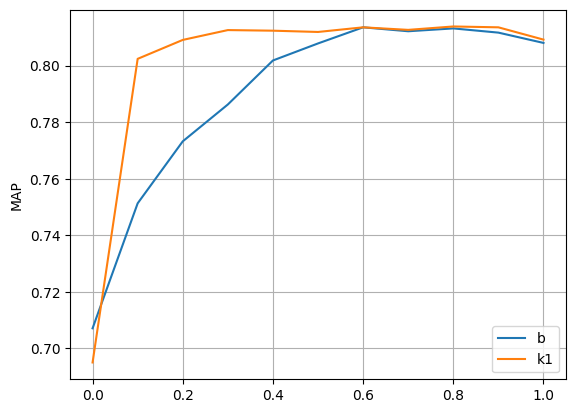

In [ ]:
from matplotlib import pyplot as plt
plt.plot(plots_b["X"], plots_b["Y"], label="b")
plt.plot(plots_k1["X"], plots_k1["Y"], label="k1")
plt.ylabel("MAP")
plt.legend()
plt.grid()
plt.show()

Let's check the effectiveness gain on test after this tuning on dev

In [ ]:
default_map = 0.7849
best_b = plots_b["X"][np.argmax(plots_b["Y"])]
best_k1 = plots_k1["X"][np.argmax(plots_k1["Y"])]
bm25_index = BM25Index.build_from_documents(
    documents=iter(sciq.corpus),
    ndocs=12160,
    show_progress_bar=True,
    k1=best_k1,
    b=best_b
)
bm25_index.save("output/bm25_index")
bm25_retriever = BM25Retriever(index_dir="output/bm25_index")
rankings = {}
for query in sciq.get_split_queries(Split.test):  # note this is now on test
  ranking = bm25_retriever.retrieve(query=query.text)
  rankings[query.query_id] = ranking
optimized_map = evaluate_map(rankings, split=Split.test)  # note this is now on test
print(default_map, optimized_map)

Regularizing TFs: 100%|██████████| 22683/22683 [00:00<00:00, 67362.10it/s]


0.7849 0.7990718090889324


# TASK2: CSC matrix and `CSCBM25Index` (12 points)

Recall that we use Python lists to implement posting lists, mapping term IDs to the documents in which they appear. This is inefficient due to its naive design. Actually [Compressed Sparse Column matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html) is very suitable for storing the posting lists and can boost the efficiency.

## TASK2.1: learn about `scipy.sparse.csc_matrix` (2 point)

Convert the matrix \begin{bmatrix}
0 & 1 & 0 & 3 \\
10 & 2 & 1 & 0 \\
0 & 0 & 0 & 9
\end{bmatrix} to a `csc_matrix` by specifying `data`, `indices`, `indptr` and `shape`. **You can hardcode the required values for this task and do not need to do it automatically.**

In [ ]:
from scipy.sparse._csc import csc_matrix
input_matrix = [[0, 1, 0, 3], [10, 2, 1, 0], [0, 0, 0, 9]]
data = None
indices = None
indptr = None
shape = None
## YOUR_CODE_STARTS_HERE
# Please assign the values to data, indices, indptr and shape
## YOUR_CODE_ENDS_HERE
output_matrix = csc_matrix((data, indices, indptr), shape=shape)

In [ ]:
## RESULT_CHECKING_POINT
print((output_matrix.indices + output_matrix.data).tolist())

## TASK2.2: implement `CSCBM25Index` (4 points)

Implement `CSCBM25Index` by completing the missing code.

In [ ]:
@dataclass
class CSCInvertedIndex:
    posting_lists_matrix: csc_matrix  # docid -> posting_list
    vocab: Dict[str, int]
    cid2docid: Dict[str, int]  # collection_id -> docid
    collection_ids: List[str]  # docid -> collection_id
    doc_texts: Optional[List[str]] = None  # docid -> document text

    def save(self, output_dir: str) -> None:
        os.makedirs(output_dir, exist_ok=True)
        with open(os.path.join(output_dir, "index.pkl"), "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def from_saved(cls: Type[T], saved_dir: str) -> T:
        index = cls(
            posting_lists_matrix=None, vocab={}, cid2docid={}, collection_ids=[], doc_texts=None
        )
        with open(os.path.join(saved_dir, "index.pkl"), "rb") as f:
            index = pickle.load(f)
        return index

In [ ]:
@dataclass
class CSCBM25Index(CSCInvertedIndex):

    @staticmethod
    def tokenize(text: str) -> List[str]:
        return simple_tokenize(text)

    @staticmethod
    def cache_term_weights(
        posting_lists: List[PostingList],
        total_docs: int,
        avgdl: float,
        dfs: List[int],
        dls: List[int],
        k1: float,
        b: float,
    ) -> csc_matrix:
        """Compute term weights and caching"""

        ## YOUR_CODE_STARTS_HERE
        ## YOUR_CODE_ENDS_HERE

    @staticmethod
    def calc_regularized_tf(
        tf: int, dl: float, avgdl: float, k1: float, b: float
    ) -> float:
        return tf / (tf + k1 * (1 - b + b * dl / avgdl))

    @staticmethod
    def calc_idf(df: int, N: int):
        return math.log(1 + (N - df + 0.5) / (df + 0.5))

    @classmethod
    def build_from_documents(
        cls: Type[CSCBM25Index],
        documents: Iterable[Document],
        store_raw: bool = True,
        output_dir: Optional[str] = None,
        ndocs: Optional[int] = None,
        show_progress_bar: bool = True,
        k1: float = 0.9,
        b: float = 0.4,
    ) -> CSCBM25Index:
        # Counting TFs, DFs, doc_lengths, etc.:
        counting = run_counting(
            documents=documents,
            tokenize_fn=CSCBM25Index.tokenize,
            store_raw=store_raw,
            ndocs=ndocs,
            show_progress_bar=show_progress_bar,
        )

        # Compute term weights and caching:
        posting_lists = counting.posting_lists
        total_docs = len(counting.cid2docid)
        posting_lists_matrix = CSCBM25Index.cache_term_weights(
            posting_lists=posting_lists,
            total_docs=total_docs,
            avgdl=counting.avgdl,
            dfs=counting.dfs,
            dls=counting.dls,
            k1=k1,
            b=b,
        )

        # Assembly and save:
        index = CSCBM25Index(
            posting_lists_matrix=posting_lists_matrix,
            vocab=counting.vocab,
            cid2docid=counting.cid2docid,
            collection_ids=counting.collection_ids,
            doc_texts=counting.doc_texts,
        )
        return index

csc_bm25_index = CSCBM25Index.build_from_documents(
    documents=iter(sciq.corpus),
    ndocs=12160,
    show_progress_bar=True,
    k1=best_k1,
    b=best_b
)
csc_bm25_index.save("output/csc_bm25_index")

Regularizing TFs: 100%|██████████| 22683/22683 [00:00<00:00, 56830.35it/s]


In [ ]:
## RESULT_CHECKING_POINT
print(os.path.getsize("output/csc_bm25_index/index.pkl"))

We can compare the size of the CSC-based index with the Python-list-based index:

In [ ]:
print(os.path.getsize("output/bm25_index/index.pkl"))

11624459


## TASK2.3: implement `CSCInvertedIndexRetriever` (1 + 5 points)

Implement `CSCInvertedIndexRetriever` by completing the missing code.

In [ ]:
class BaseCSCInvertedIndexRetriever(BaseRetriever):

    @property
    @abstractmethod
    def index_class(self) -> Type[CSCInvertedIndex]:
        pass

    def __init__(self, index_dir: str) -> None:
        self.index = self.index_class.from_saved(index_dir)

    def get_term_weights(self, query: str, cid: str) -> Dict[str, float]:
        ## YOUR_CODE_STARTS_HERE
        ## YOUR_CODE_ENDS_HERE

    def score(self, query: str, cid: str) -> float:
        return sum(self.get_term_weights(query=query, cid=cid).values())

    def retrieve(self, query: str, topk: int = 10) -> Dict[str, float]:
        ## YOUR_CODE_STARTS_HERE
        ## YOUR_CODE_ENDS_HERE


class CSCBM25Retriever(BaseCSCInvertedIndexRetriever):

    @property
    def index_class(self) -> Type[CSCBM25Index]:
        return CSCBM25Index

In [ ]:
## RESULT_CHECKING_POINT
csc_bm25_retriever = CSCBM25Retriever(index_dir="output/csc_bm25_index")
query = "What are the differences between immunodeficiency and autoimmune diseases?"
print(csc_bm25_retriever.get_term_weights(query=query, cid="train-1691"))  # 1 point
print(csc_bm25_retriever.retrieve("What are the differences between immunodeficiency and autoimmune diseases?"))  # 5 points

# TASK3: a search-engine demo based on Huggingface space (4 points)

## TASK3.1: create the gradio app (2 point)

Create a gradio app to demo the BM25 search engine index on SciQ. The app should have a single input variable for the query (of type `str`) and a single output variable for the returned ranking (of type `List[Hit]` in the code below).

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
from typing import TypedDict

class Hit(TypedDict):
  cid: str
  score: float
  text: str

demo: Optional[gr.Interface] = None  # Assign your gradio demo to this variable
return_type = List[Hit]

## YOUR_CODE_STARTS_HERE
## YOUR_CODE_ENDS_HERE
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ca3d010a662a4fa001.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
## RESULT_CHECKING_POINT
import requests
import json

headers = {"Content-Type": "application/json"}
data = {"data": ["What are the differences between immunodeficiency and autoimmune diseases?"]}
response = requests.post(f"{demo.local_api_url.strip('/')}/call/predict", headers=headers, data=json.dumps(data))
event_id = response.json()["event_id"]
response = requests.get(f"{demo.local_api_url.strip('/')}/call/predict/{event_id}", stream=True)
lines = list(response.iter_lines())
print(eval(json.loads(lines[1].decode("UTF-8").replace("data:", ""))[0]))

## TASK3.2: upload it to Huggingface Space (2 point)

Upload your gradio app to Huggingface Space. Put your URL to the Space app in the variable `hf_space_url`. You can get this URL from:

*Your Space page* -> *"three dots" on the top right* -> "embedd this space" -> "Direct URL"

In [ ]:
hf_space_url: Optional[str] = None  # Store your created Huggingface Space URL in this variable
## YOUR_CODE_STARTS_HERE
## YOUR_CODE_ENDS_HERE

## RESULT_CHECKING_POINT
import requests
import json

print(hf_space_url)
headers = {"Content-Type": "application/json"}
data = {"data": ["What are the differences between immunodeficiency and autoimmune diseases?"]}
response = requests.post(f"{hf_space_url.strip('/')}/call/predict", headers=headers, data=json.dumps(data))
event_id = response.json()["event_id"]
response = requests.get(f"{hf_space_url.strip('/')}/call/predict/{event_id}", stream=True)
lines = list(response.iter_lines())
print(eval(json.loads(lines[1].decode("UTF-8").replace("data:", ""))[0]))